In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = Path(".")

In [4]:
path.ls()

[PosixPath('froth.ipynb'),
 PosixPath('images'),
 PosixPath('label_to_mask.py'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('labels'),
 PosixPath('codes.txt')]

In [5]:
path_lbl = path/"labels"
path_img = path/"images"

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('images/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('images/1575363424_5842041f4e65fad6a7708844.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('labels/1575363424_5842041f4e65fad6a7708805.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a7708832.png'),
 PosixPath('labels/1575363424_5842041f4e65fad6a7708844.png')]

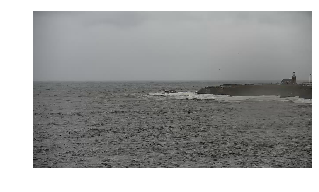

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f"{x.stem}{x.suffix}"

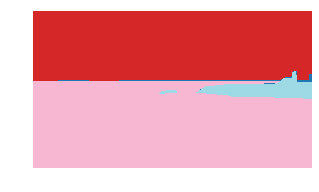

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 720, 1280]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['__ignore__', '_background_', 'Sky', 'Ocean', 'Ground'], dtype='<U12')

In [13]:
size = src_size//2
bs=4

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

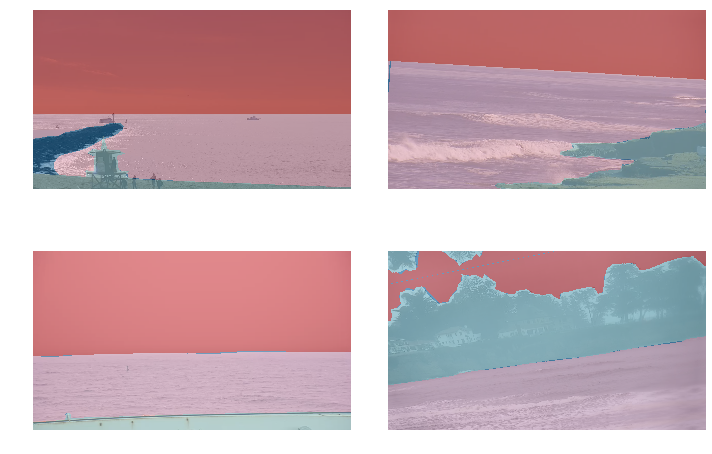

In [16]:
data.show_batch(2, figsize=(10,7))

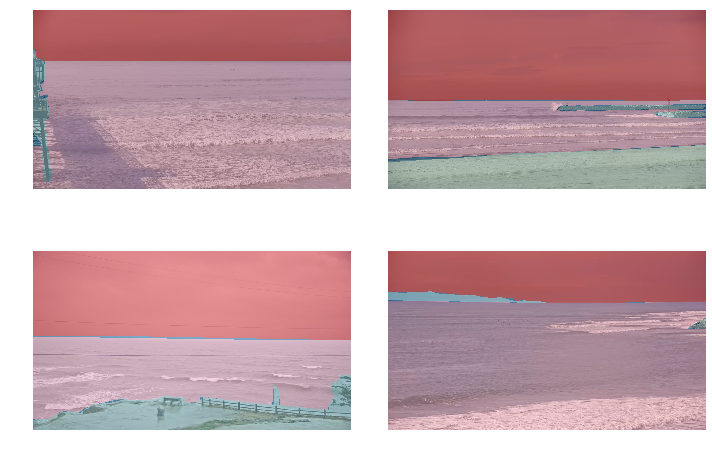

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Stage 1

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
ignore_code = name2id['__ignore__']

def acc_labelme(input, target):
    target = target.squeeze(1)
    mask = target != ignore_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_labelme

In [20]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


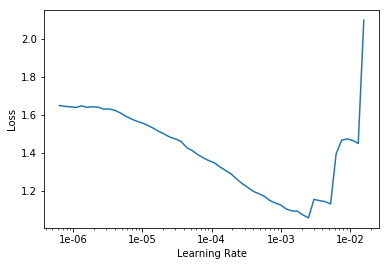

In [22]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_labelme,time
0,0.855629,0.679669,0.829317,00:12
1,0.716322,0.646959,0.829001,00:12
2,0.602262,0.393174,0.896673,00:12
3,0.530577,0.584459,0.837149,00:12
4,0.522427,0.898341,0.780096,00:12
5,0.503617,0.764094,0.791915,00:12
6,0.497640,0.579817,0.839278,00:12
7,0.501583,0.492846,0.869041,00:12
8,0.484051,0.557486,0.846992,00:12
9,0.444215,0.490012,0.869956,00:12


In [28]:
learn.save('stage-1b')

In [29]:
learn.load('stage-1b');

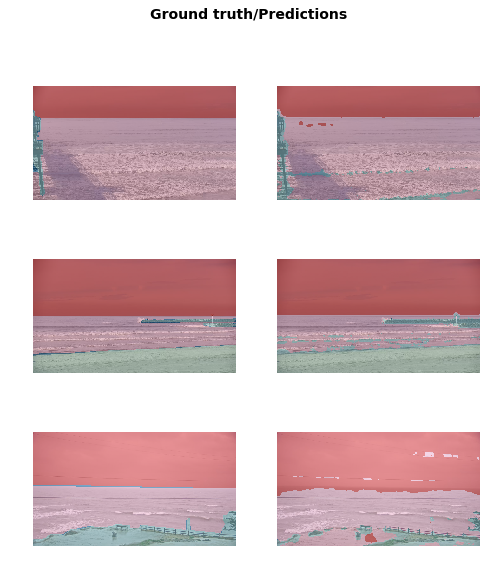

In [30]:
learn.show_results(rows=3, figsize=(8,9))

# Stage 2

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_labelme,time
0,0.296548,0.406210,0.884298,00:13
1,0.292282,0.333466,0.896518,00:12
2,0.279228,0.355615,0.897750,00:12
3,0.275665,0.316741,0.919850,00:12
4,0.263600,0.238017,0.930284,00:13
5,0.266317,0.319016,0.920291,00:12
6,0.252080,0.323917,0.927629,00:13
7,0.294146,0.506183,0.899166,00:13
8,0.328398,0.906005,0.777438,00:13
9,0.349118,0.386712,0.881931,00:12


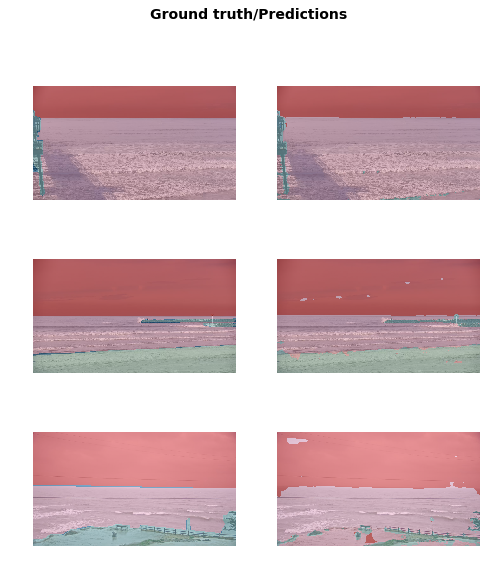

In [34]:
learn.show_results(rows=3, figsize=(8,9))

In [35]:
learn.save('stage-2b')

# Stage 3 (Big)

In [36]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [37]:
size = src_size

In [38]:
bs=1

In [39]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [40]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [41]:
learn.load('stage-2b')

Learner(data=ImageDataBunch;

Train: LabelList (33 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Valid: LabelList (8 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPoo

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


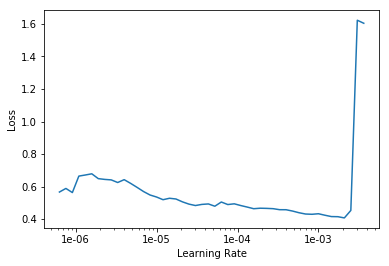

In [43]:
lr_find(learn)
learn.recorder.plot()

In [44]:
lr=2e-3

In [45]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_labelme,time
0,0.338548,0.468165,0.847969,00:46
1,0.340975,0.456664,0.866015,00:46
2,0.343179,0.528681,0.869506,00:46
3,0.425209,0.824941,0.835658,00:46
4,0.420937,1.016088,0.821144,00:46
5,0.458391,0.918849,0.856895,00:46
6,0.614019,0.910733,0.816105,00:46
7,0.645287,0.886053,0.834574,00:46
8,0.554222,0.733566,0.832507,00:46
9,0.475595,0.727359,0.843306,00:46


In [46]:
learn.save('stage-3b')

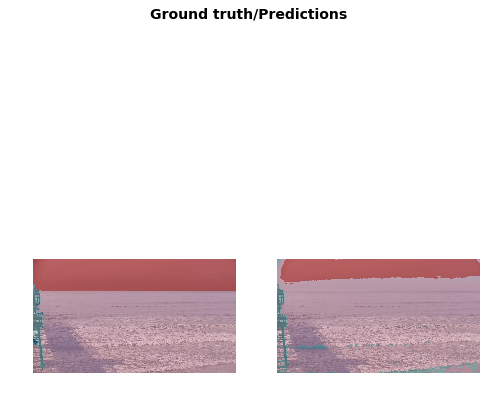

In [47]:
learn.show_results(rows=3, figsize=(8,9))

# Export

In [48]:
learn.load('stage-3b')

Learner(data=ImageDataBunch;

Train: LabelList (33 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Valid: LabelList (8 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPoo

In [49]:
learn.export()